In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#!pip uninstall -y torchaudio torchvision # Uninstall conflicting packages
#!pip uninstall -y autogluon.timeseries # Uninstall old autogluon.timeseries
#!pip install autogluon.timeseries # Install autogluon.timeseries
import autogluon as ag
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Consolidate Data Loading and Train-Test Split

This step refines the initial data loading process, ensuring proper handling of missing values and a robust train-test split to prevent data leakage. The `df_full` DataFrame is cleaned, and then explicitly divided into `df_train_original` and `df_test_original`.

In [2]:
df_full = pd.read_excel('Data_Set_M2_Final.xlsx') # Read Excel file into df_full
df_full["Date"] = pd.to_datetime(df_full["Date"], format='%d.%m.%Y %H:%M') # Convert to datetime format
df_full = df_full.rename(columns={'Total System Imbalance (Positiv = long / Negativ = short)': 'Imbalance'}) # Rename column

# Drop NaN values specifically from the 'Imbalance' column and assign back to df_full
df_full = df_full.dropna(subset=['Imbalance'])

test_period_length_15min = 96 # Define test period length (96 15-minute intervals = 24 hours)
df_train_original = df_full.iloc[:-test_period_length_15min].copy() # Create training set
df_test_original = df_full.iloc[-test_period_length_15min:].copy() # Create test set

print("Shape of df_full:", df_full.shape)
print("Shape of df_train_original:", df_train_original.shape)
print("Shape of df_test_original:", df_test_original.shape)

Shape of df_full: (107040, 31)
Shape of df_train_original: (106944, 31)
Shape of df_test_original: (96, 31)


### Prepare Baseline Training Data

This section prepares the `system_imbalance_ts` DataFrame from `df_train_original` for the baseline model. It renames columns, adds an ID, converts to hourly frequency, and applies interpolation for missing values.

In [3]:
system_imbalance_ts = df_train_original[["Date","Imbalance"]].copy() # Select columns and create a new DataFrame as a copy
system_imbalance_ts.rename(columns={"Date": "datetime", "Imbalance":"target"}, inplace=True) # Rename columns
system_imbalance_ts["ID"] = "imbalance" # Add 'ID' column

# Convert to TimeSeriesDataFrame for frequency conversion and imputation
system_imbalance_ts = TimeSeriesDataFrame.from_data_frame(
    system_imbalance_ts,
    id_column= "ID" ,
    timestamp_column= "datetime"  ,
)

# Convert the data to hourly frequency
system_imbalance_ts = system_imbalance_ts.convert_frequency(freq="h", agg_numeric= "mean")
# Fill missing values using interpolation
system_imbalance_ts = system_imbalance_ts.fill_missing_values(method = "interpolate")
# Sort the values
system_imbalance_ts.sort_values(by="timestamp", inplace=True)

system_imbalance_ts.head() # Display the first few rows

target
item_id   timestamp                   
imbalance 2022-08-13 00:00:00 -42.3050
          2022-08-13 01:00:00 -11.0650
          2022-08-13 02:00:00   2.1700
          2022-08-13 03:00:00  16.1575
          2022-08-13 04:00:00  -1.7050

### Prepare Baseline Test Data

This section prepares the `system_imbalance_ts_test` DataFrame from `df_test_original`, applying the same preprocessing steps as the training data to ensure consistency for baseline evaluation.

In [4]:
system_imbalance_ts_test = df_test_original[["Date","Imbalance"]].copy() # Create a new DataFrame and ensure it's a copy
system_imbalance_ts_test.rename(columns={"Date": "datetime", "Imbalance":"target"}, inplace=True) # Rename columns
system_imbalance_ts_test["ID"] = "imbalance" # Add 'ID' column

# Convert to TimeSeriesDataFrame for frequency conversion and imputation
system_imbalance_ts_test = TimeSeriesDataFrame.from_data_frame(
    system_imbalance_ts_test,
    id_column= "ID" ,
    timestamp_column= "datetime"  ,
)

# Convert the data to hourly frequency
system_imbalance_ts_test = system_imbalance_ts_test.convert_frequency(freq="h", agg_numeric= "mean")
# Fill missing values using interpolation
system_imbalance_ts_test = system_imbalance_ts_test.fill_missing_values(method = "interpolate")
# Sort the values
system_imbalance_ts_test.sort_values(by="timestamp", inplace=True)

system_imbalance_ts_test.head() # Display the first few rows

target
item_id   timestamp                   
imbalance 2025-08-31 00:00:00  62.3500
          2025-08-31 01:00:00  49.6375
          2025-08-31 02:00:00  44.8700
          2025-08-31 03:00:00  35.8675
          2025-08-31 04:00:00   4.3600

### Calculate Naive Baseline MAE

This step establishes a simple naive baseline model for comparison. It predicts the last known value from the training set for all periods in the test set and calculates the Mean Absolute Error (MAE).

In [5]:
last_train_value = system_imbalance_ts["target"].iloc[-1] # Extract the last target value from the training set
actual_test_values = system_imbalance_ts_test["target"] # Extract the actual target values from the test set

# Create a naive prediction series by repeating the last training target value
naive_predictions = np.full_like(actual_test_values.values, last_train_value)

# Calculate the Mean Absolute Error (MAE)
naive_mae = mean_absolute_error(actual_test_values, naive_predictions)

print(f"Naive Baseline MAE: {naive_mae}")

Naive Baseline MAE: 101.76541666666667


### Feature Engineering for Covariates (Training Data)

This section enhances the training data by adding external features (`GST_Average`, `Temp_Average`) and engineering cyclical temporal features (sine/cosine transformations for 'Weekday', 'Hour_of_day', 'Month_of_year') to better capture periodic patterns. 'Season' is included as a numeric covariate. Missing values are imputed using interpolation.

In [6]:
external_features = df_train_original[['Date', 'Imbalance', 'GST_Average', 'Temp_Average']].copy() # Create external_features DataFrame
external_features.rename(columns={"Date": "datetime", "Imbalance":"target"}, inplace=True) # Rename columns
external_features["item_id"] = "imbalance" # Add 'item_id' column

# Convert to TimeSeriesDataFrame
external_features = TimeSeriesDataFrame.from_data_frame(
    external_features,
    id_column= "item_id" ,
    timestamp_column= "datetime"  ,
)

# Convert the data to hourly frequency
external_features = external_features.convert_frequency(freq="h", agg_numeric= "mean")
# Fill missing values using interpolation
external_features = external_features.fill_missing_values(method = "interpolate")

# Extract timestamps
timestamps_train = external_features.index.get_level_values("timestamp")

# Add 'Season' as a numerical covariate
external_features["Season"] = ((timestamps_train.month%12 + 3)//3)

# Create cyclical sine and cosine features for 'Weekday', 'Hour_of_day', and 'Month_of_year'
external_features["Weekday_sin"] = np.sin(2 * np.pi * timestamps_train.weekday / 7)
external_features["Weekday_cos"] = np.cos(2 * np.pi * timestamps_train.weekday / 7)
external_features["Hour_of_day_sin"] = np.sin(2 * np.pi * timestamps_train.hour / 24)
external_features["Hour_of_day_cos"] = np.cos(2 * np.pi * timestamps_train.hour / 24)
external_features["Month_of_year_sin"] = np.sin(2 * np.pi * (timestamps_train.month - 1) / 12)
external_features["Month_of_year_cos"] = np.cos(2 * np.pi * (timestamps_train.month - 1) / 12)

external_features.head() # Display the first few rows

target  GST_Average  Temp_Average  Season  \
item_id   timestamp                                                         
imbalance 2022-08-13 00:00:00 -42.3050          0.0         -2.15       3   
          2022-08-13 01:00:00 -11.0650          0.0         -2.45       3   
          2022-08-13 02:00:00   2.1700          0.0         -1.72       3   
          2022-08-13 03:00:00  16.1575          0.0         -1.53       3   
          2022-08-13 04:00:00  -1.7050          0.0         -1.32       3   

                               Weekday_sin  Weekday_cos  Hour_of_day_sin  \
item_id   timestamp                                                        
imbalance 2022-08-13 00:00:00    -0.974928    -0.222521         0.000000   
          2022-08-13 01:00:00    -0.974928    -0.222521         0.258819   
          2022-08-13 02:00:00    -0.974928    -0.222521         0.500000   
          2022-08-13 03:00:00    -0.974928    -0.222521         0.707107   
          2022-08-13 04:00:00    -0.974928    -0.222521         0.866025   

                               Hour_of_day_cos  Month_of_year_sin  \
item_id   timestamp                                                 
imbalance 2022-08-13 00:00:00         1.000000               -0.5   
          2022-08-13 01:00:00         0.965926               -0.5   
          2022-08-13 02:00:00         0.866025               -0.5   
          2022-08-13 03:00:00         0.707107               -0.5   
          2022-08-13 04:00:00         0.500000               -0.5   

                               Month_of_year_cos  
item_id   timestamp                               
imbalance 2022-08-13 00:00:00          -0.866025  
          2022-08-13 01:00:00          -0.866025  
          2022-08-13 02:00:00          -0.866025  
          2022-08-13 03:00:00          -0.866025  
          2022-08-13 04:00:00          -0.866025

### Feature Engineering for Covariates (Test Data)

This section prepares the test data with the same external and cyclical temporal features as the training data. It also creates the `known_covariates` DataFrame, which will be provided to the AutoGluon predictor for forecasting. This ensures that the test data aligns with the model's expectations during prediction.

In [7]:
external_features_test = df_test_original[['Date', 'Imbalance', 'GST_Average', 'Temp_Average']].copy() # Create external_features_test DataFrame
external_features_test.rename(columns={"Date": "datetime", "Imbalance":"target"}, inplace=True) # Rename columns
external_features_test["item_id"] = "imbalance" # Add 'item_id' column

# Convert to TimeSeriesDataFrame
external_features_test = TimeSeriesDataFrame.from_data_frame(
    external_features_test,
    id_column= "item_id" ,
    timestamp_column= "datetime"  ,
)

# Convert the data to hourly frequency
external_features_test = external_features_test.convert_frequency(freq="h", agg_numeric= "mean")
# Fill missing values using interpolation
external_features_test = external_features_test.fill_missing_values(method = "interpolate")

# Extract timestamps
timestamps_test = external_features_test.index.get_level_values("timestamp")

# Add 'Season' as a numerical covariate
external_features_test["Season"] = ((timestamps_test.month%12 + 3)//3)

# Create cyclical temporal features using sine and cosine transformations
external_features_test["Weekday_sin"] = np.sin(2 * np.pi * timestamps_test.weekday / 7)
external_features_test["Weekday_cos"] = np.cos(2 * np.pi * timestamps_test.weekday / 7)
external_features_test["Hour_of_day_sin"] = np.sin(2 * np.pi * timestamps_test.hour / 24)
external_features_test["Hour_of_day_cos"] = np.cos(2 * np.pi * timestamps_test.hour / 24)
external_features_test["Month_of_year_sin"] = np.sin(2 * np.pi * (timestamps_test.month - 1) / 12)
external_features_test["Month_of_year_cos"] = np.cos(2 * np.pi * (timestamps_test.month - 1) / 12)

# Create known_covariates by dropping the 'target' and past covariates
# The known_covariates DataFrame should contain only the features that are known at prediction time.
# GST_Average and Temp_Average will be inferred as past_covariates by AutoGluon, so we drop them from known_covariates.
known_covariates = external_features_test.drop(columns=["target", "GST_Average", "Temp_Average"])

external_features_test.head() # Display the first few rows of external_features_test
known_covariates.tail() # Display the last few rows of known_covariates

Season  Weekday_sin  Weekday_cos  \
item_id   timestamp                                               
imbalance 2025-08-31 19:00:00       3    -0.781831      0.62349   
          2025-08-31 20:00:00       3    -0.781831      0.62349   
          2025-08-31 21:00:00       3    -0.781831      0.62349   
          2025-08-31 22:00:00       3    -0.781831      0.62349   
          2025-08-31 23:00:00       3    -0.781831      0.62349   

                               Hour_of_day_sin  Hour_of_day_cos  \
item_id   timestamp                                               
imbalance 2025-08-31 19:00:00        -0.965926         0.258819   
          2025-08-31 20:00:00        -0.866025         0.500000   
          2025-08-31 21:00:00        -0.707107         0.707107   
          2025-08-31 22:00:00        -0.500000         0.866025   
          2025-08-31 23:00:00        -0.258819         0.965926   

                               Month_of_year_sin  Month_of_year_cos  
item_id   timestamp                                                  
imbalance 2025-08-31 19:00:00               -0.5          -0.866025  
          2025-08-31 20:00:00               -0.5          -0.866025  
          2025-08-31 21:00:00               -0.5          -0.866025  
          2025-08-31 22:00:00               -0.5          -0.866025  
          2025-08-31 23:00:00               -0.5          -0.866025

### Train AutoGluon Predictor with Covariates

This step initializes and trains the `TimeSeriesPredictor` with the enhanced training data, leveraging the newly engineered cyclical temporal features as `known_covariates`. `high_quality` presets are used for comprehensive model exploration.

In [9]:
known_covariates_list = [
    "Season", # Include Season as a known covariate
    "Weekday_sin", "Weekday_cos",
    "Hour_of_day_sin", "Hour_of_day_cos",
    "Month_of_year_sin", "Month_of_year_cos"
]

predictor_covariates = TimeSeriesPredictor(
    prediction_length=24,
    target="target",
    eval_metric="MASE",
    path="autogluon-m4-hourly-covariates-cyclical", # New path to avoid overwriting previous models
    known_covariates_names=known_covariates_list,
    )

predictor_covariates.fit(
    external_features,
    presets="high_quality",
    time_limit=600
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/content/autogluon-m4-hourly-covariates-cyclical'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       10.91 GB / 12.67 GB (86.1%)
Disk Space Avail:   63.16 GB / 107.72 GB (58.6%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'default',
 'known_covariates_names': ['Season',
                            'Weekday_sin',
                            'Weekday_cos',
                            'Hour_of_day_sin',
                            'Hour_of_day_cos',
                            'Month_of_year_sin',
                            'Month_of_year_cos'],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile

┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   ┃ Name  ┃ Type                    ┃ Params ┃ Mode  ┃ FLOPs ┃               In sizes ┃               Out sizes ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 0 │ model │ TemporalFusionTransfor… │  138 K │ train │ 9.0 M │ [[1, 64], [1, 64], [1, │  [[[1, 24, 9]], [1, 1], │
│   │       │                         │        │       │       │    1], [1, 1], [1, 88, │                 [1, 1]] │
│   │       │                         │        │       │       │   11], [1, 88, 0], [1, │                         │
│   │       │                         │        │       │       │    64, 2], [1, 64, 0]] │                         │
└───┴───────┴─────────────────────────┴────────┴───────┴───────┴────────────────────────┴─────────────────────────┘

Trainable params: 138 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 138 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 256                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 9.0 M

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/trainer.py", line 357, in _train_and_save
    model = self._train_single(train_data, model, val_data=val_data, time_limit=time_limit)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/trainer.py", line 273, in _train_single
    model.fit(
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/models/abstract/abstract_timeseries_model.py", line 515, in fit
    self._fit(
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/models/multi_window/multi_window_model.py", line 137, in _fit
    model.fit(
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/models/abstract/abstract_timeseries_model.py", line 515, in fit
    self._fit(
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/models/gluonts/abstract.py", line 4

┏━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃   ┃ Name  ┃ Type        ┃ Params ┃ Mode  ┃ FLOPs ┃                                      In sizes ┃    Out sizes ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 0 │ model │ DeepARModel │ 28.8 K │ train │ 563 K │  [[1, 1], [1, 1], [1, 768, 12], [1, 768], [1, │ [1, 100, 24] │
│   │       │             │        │       │       │                            768], [1, 24, 12]] │              │
└───┴───────┴─────────────┴────────┴───────┴───────┴───────────────────────────────────────────────┴──────────────┘

Trainable params: 28.8 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 28.8 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 11                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 563 K

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/trainer.py", line 357, in _train_and_save
    model = self._train_single(train_data, model, val_data=val_data, time_limit=time_limit)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/trainer.py", line 273, in _train_single
    model.fit(
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/models/abstract/abstract_timeseries_model.py", line 515, in fit
    self._fit(
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/models/multi_window/multi_window_model.py", line 137, in _fit
    model.fit(
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/models/abstract/abstract_timeseries_model.py", line 515, in fit
    self._fit(
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/models/gluonts/abstract.py", line 4

┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ PatchTSTModel │  325 K │ train │     0 │
└───┴───────┴───────────────┴────────┴───────┴───────┘

Trainable params: 325 K                                                                                            
Non-trainable params: 384                                                                                          
Total params: 325 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 34                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/trainer.py", line 357, in _train_and_save
    model = self._train_single(train_data, model, val_data=val_data, time_limit=time_limit)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/trainer.py", line 273, in _train_single
    model.fit(
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/models/abstract/abstract_timeseries_model.py", line 515, in fit
    self._fit(
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/models/multi_window/multi_window_model.py", line 137, in _fit
    model.fit(
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/models/abstract/abstract_timeseries_model.py", line 515, in fit
    self._fit(
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/models/gluonts/abstract.py", line 4

┏━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type      ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ TiDEModel │  964 K │ train │     0 │
└───┴───────┴───────────┴────────┴───────┴───────┘

Trainable params: 964 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 964 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/trainer.py", line 357, in _train_and_save
    model = self._train_single(train_data, model, val_data=val_data, time_limit=time_limit)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/trainer.py", line 273, in _train_single
    model.fit(
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/models/abstract/abstract_timeseries_model.py", line 515, in fit
    self._fit(
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/models/multi_window/multi_window_model.py", line 137, in _fit
    model.fit(
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/models/abstract/abstract_timeseries_model.py", line 515, in fit
    self._fit(
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/models/gluonts/abstract.py", line 4

### Generate Predictions with Covariates

Once the AutoGluon predictor is trained, this step generates future forecasts for the test period using the model and the prepared `known_covariates`.

In [10]:
predictions_covariates = predictor_covariates.predict(external_features, known_covariates=known_covariates)

# Extract the 'mean' predictions for MAE calculation
predicted_values_covariates = predictions_covariates['mean']

# Extract the actual target values from the test set
actual_test_values_covariates = external_features_test['target']

# Calculate MAE for the AutoGluon model with covariates
autogluon_mae_covariates = mean_absolute_error(actual_test_values_covariates, predicted_values_covariates)

print(f"AutoGluon Model MAE (with covariates): {autogluon_mae_covariates}")


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


AutoGluon Model MAE (with covariates): 88.80230992048511


### Compare Performance and Visualize Results

This final step compares the performance of the AutoGluon model with covariates against the naive baseline using MAE. It also generates a visualization of the AutoGluon predictions against the actual values from the test set, including prediction intervals.

Naive Baseline MAE: 101.76541666666667
AutoGluon Model MAE (with covariates): 88.80230992048511


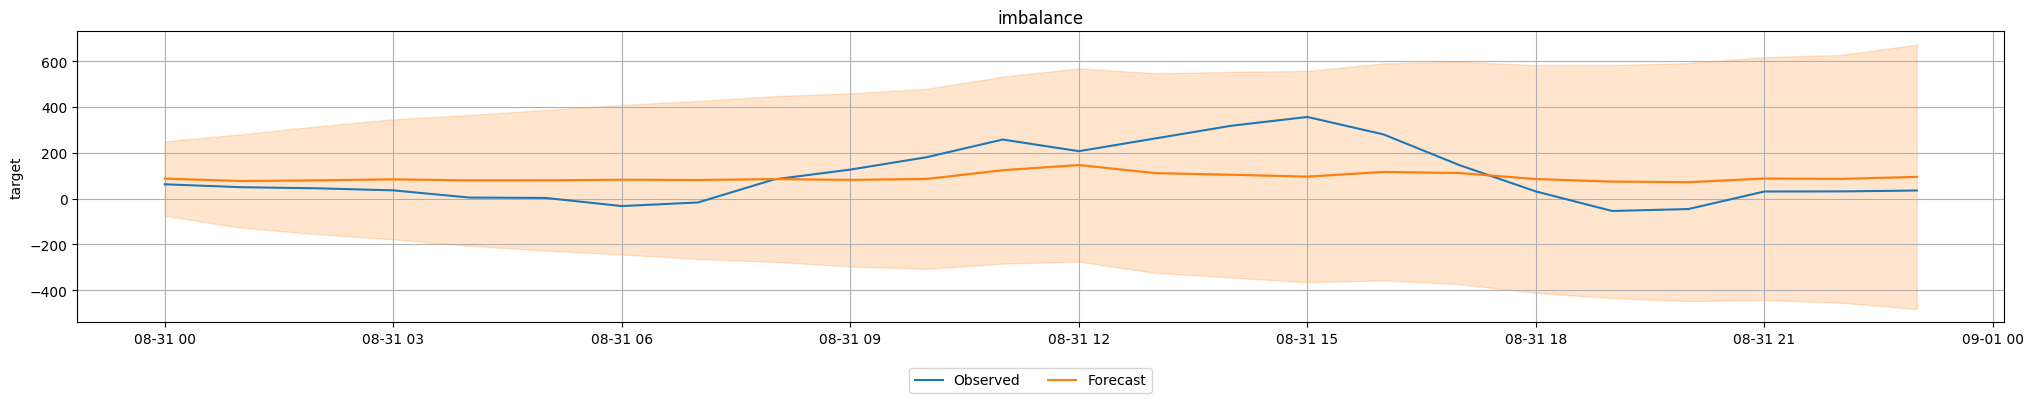

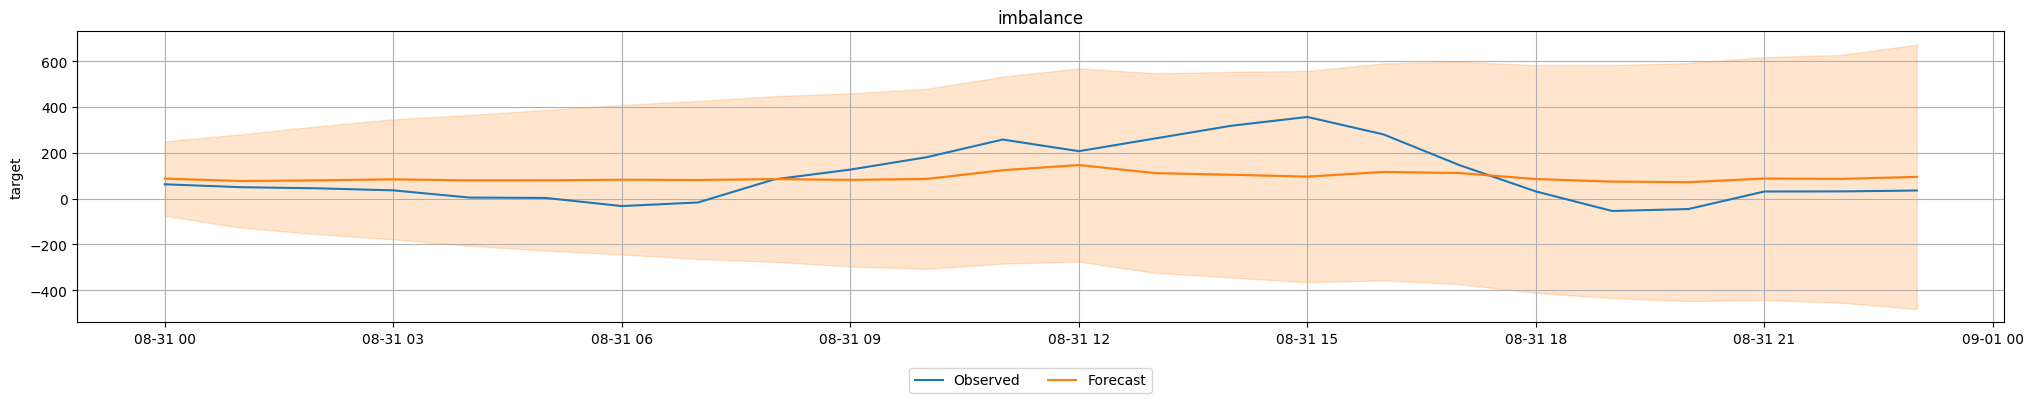

In [11]:
print(f"Naive Baseline MAE: {naive_mae}")
print(f"AutoGluon Model MAE (with covariates): {autogluon_mae_covariates}")

predictor_covariates.plot(external_features_test, predictions_covariates, quantile_levels=[0.1, 0.9], max_history_length=48)
